- Name: Mohammad Anas
- Roll Number: 20L-1289
- Question 2 
- Assignment 2
- NLP

# **Importing Required Modules**

In [38]:
import pandas as pd
import numpy as np
import re

from wordcloud import WordCloud
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from joblib import parallel_backend
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')


# **Loading the dataset**

In [11]:
df = pd.read_csv('Q2 Sentiment Analysis Dataset.csv', encoding='ISO-8859-1')
df = df[['text', 'sentiment']]
df.head()

,text,sentiment
0,WTF MY BATTERY WAS 31% ONE SECOND AGO AND NOW ...,1
1,@apple Contact sync between Yosemite and iOS8 ...,1
2,WARNING IF YOU BUY AN IPHONE 5S UNLOCKED FROM ...,1
3,"@Apple, For the love of GAWD, CENTER the '1'on...",1
4,i get the storage almost full notification lit...,1


# **Cleaning the dataset**

In [12]:
def clean_text(df):
    all_reviews = list()
    lines = df['text'].values.tolist()
    for text in lines:
        
        text = text.lower()
        
        pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
        text = pattern.sub('', text)
        
        text = re.sub(r"[,.\"!@#$%^&*(){}?/;`~:<>+=-]", "", text)
        
        tokens = word_tokenize(text)
        
        table = str.maketrans('', '', '\t')
        stripped = [w.translate(table) for w in tokens]
        word = [word for word in stripped if word.isalpha()]
        
        stop_words = set(stopwords.words('english'))
        words = [w for w in word if not w in stop_words]
        
        ps = PorterStemmer()
        words = [ps.stem(w) for w in words]
        all_reviews.append(" ".join(words))
    return all_reviews


all_text = clean_text(df)
all_text[:20]

['wtf batteri one second ago wtf appl',
 'appl contact sync yosemit serious screw use much stabl past icloud isync',
 'warn buy iphon unlock appl iphon use verizon network',
 'appl love gawd center damn calendar app fix back center',
 'get storag almost full notif liter everi minut chill appl',
 'made switch iphon galaxi note edg appl keep',
 'rt ca stand ppl appl sticker everywher prob bought ipod shuffl',
 'flash crash realli screw lot trader today im determin ever make trade work aapl',
 'nigga updat yall headphon appl',
 'rt thehil justic depart cite centuri feder law get appl unlock iphon',
 'ok appl win wo use browser anymor sinc keep close liter time today count',
 'thehil appl cite us constitut judg pass law violat separ power',
 'appl u need get ur fuck shit togeth let txt youtub',
 'thehil appl wish could prosecut admin violat privaci crimin search seizur',
 'aaplher appl drop',
 'hey appl fuck',
 'appl peopl explain precaut buy expens laptop',
 'die hard appl custom must say

# **Visualizing the WordCloud**

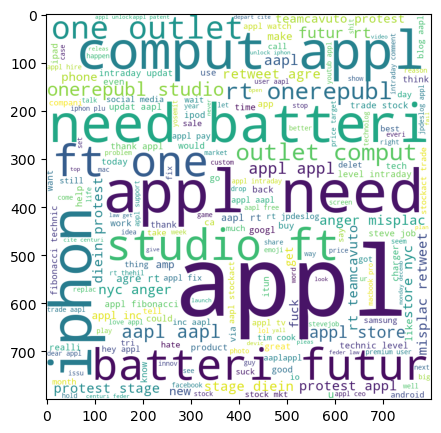

In [13]:
stop_words = set(stopwords.words('english'))
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stop_words,
                min_font_size = 10).generate(' '.join(all_text))

plt.figure(figsize = (5, 5), facecolor = None)
plt.imshow(wordcloud)


# **Loading into the required format**

In [19]:
sentiment_dict = {
    1: 'negative',
    3: 'neutral',
    5: 'positive',
    4: 'not_relevant'
}


df['sentiment'] = df['sentiment'].apply(lambda x: 4 if x == 'not_relevant' else x)
df['sentiment'] = df['sentiment'].apply(lambda x: int(x))
df['sentiment'].value_counts()

sentiment
3    2162
1    1219
5     423
4      82
Name: count, dtype: int64

# **Visualizing the class distribution**

<Axes: xlabel='sentiment'>

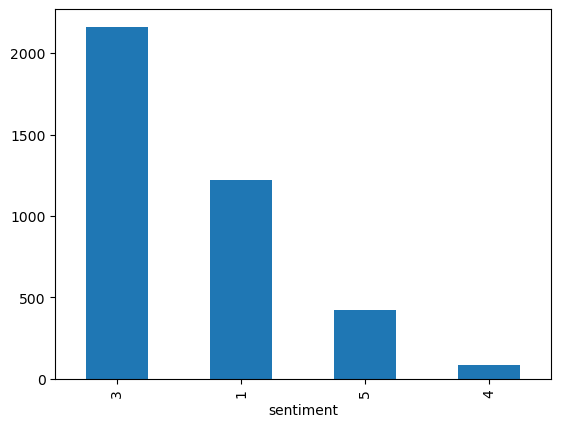

In [18]:
df['sentiment'].value_counts().plot(kind='bar')

# **Training pipeline**

In [46]:
classifiers = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'Perceptron': Perceptron()
}

vectorizers = {
    'Raw Counts': CountVectorizer(),
    'TF-IDF': TfidfVectorizer(),
    'ngrams': CountVectorizer(ngram_range=(1, 3))
}

for classifier_name, classifier in classifiers.items():
    for vectorizer_name, vectorizer in vectorizers.items():
        print(f'TO BE TRAINED WITH: {classifier_name} with {vectorizer_name}')

X = all_text
y = df['sentiment']

X_vectorized = {}
for vectorizer_name, vectorizer in vectorizers.items():
    X_vectorized[vectorizer_name] = vectorizer.fit_transform(X)

results = []

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

total_iterations = len(classifiers) * len(vectorizers)
progress_bar = tqdm(total=total_iterations, desc="Training")

for classifier_name, classifier in classifiers.items():
    for vectorizer_name, X_train_vectorized in X_vectorized.items():
        progress_bar.set_description(
            f'Training {classifier_name} with {vectorizer_name}')
        
        accuracy_scores = []
        precision_scores = []
        recall_scores = []
        f1_scores = []

        with parallel_backend('threading', n_jobs=-1):
            y_pred = cross_val_predict(
                classifier, X_train_vectorized, y, cv=skf, n_jobs=-1)

        accuracy_scores.append(accuracy_score(y, y_pred))
        precision, recall, f1, _ = precision_recall_fscore_support(
            y, y_pred, average='weighted')
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)

        micro_precision, micro_recall, micro_f1, _ = precision_recall_fscore_support(
            y, y_pred, average='micro')
        macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(
            y, y_pred, average='macro')

        results.append({'Classifier': classifier_name, 'Vectorizer': vectorizer_name,
                        'Accuracy': accuracy_scores[0], 'Precision': precision_scores[0],
                        'Recall': recall_scores[0], 'F1 Score': f1_scores[0],
                        'Micro Accuracy': accuracy_scores[0],
                        'Micro Precision': micro_precision,
                        'Micro Recall': micro_recall,
                        'Micro F1 Score': micro_f1,
                        'Macro Precision': macro_precision,
                        'Macro Recall': macro_recall,
                        'Macro F1 Score': macro_f1})
        
        progress_bar.update(1)

progress_bar.close()

TO BE TRAINED WITH: Naive Bayes with Raw Counts
TO BE TRAINED WITH: Naive Bayes with TF-IDF
TO BE TRAINED WITH: Naive Bayes with ngrams
TO BE TRAINED WITH: Logistic Regression with Raw Counts
TO BE TRAINED WITH: Logistic Regression with TF-IDF
TO BE TRAINED WITH: Logistic Regression with ngrams
TO BE TRAINED WITH: Random Forest with Raw Counts
TO BE TRAINED WITH: Random Forest with TF-IDF
TO BE TRAINED WITH: Random Forest with ngrams
TO BE TRAINED WITH: SVM with Raw Counts
TO BE TRAINED WITH: SVM with TF-IDF
TO BE TRAINED WITH: SVM with ngrams
TO BE TRAINED WITH: Perceptron with Raw Counts
TO BE TRAINED WITH: Perceptron with TF-IDF
TO BE TRAINED WITH: Perceptron with ngrams


Training Perceptron with ngrams: 100%|██████████| 15/15 [01:15<00:00,  5.00s/it]            


# **Evaluation**

In [47]:
df_results = pd.DataFrame(results)
df_results

,Classifier,Vectorizer,Accuracy,Precision,Recall,F1 Score,Micro Accuracy,Micro Precision,Micro Recall,Micro F1 Score,Macro Precision,Macro Recall,Macro F1 Score
0,Naive Bayes,Raw Counts,0.698405,0.693334,0.698405,0.691953,0.698405,0.698405,0.698405,0.698405,0.584129,0.496225,0.511962
1,Naive Bayes,TF-IDF,0.725939,0.730198,0.725939,0.681510,0.725939,0.725939,0.725939,0.725939,0.590284,0.412568,0.407379
2,Naive Bayes,ngrams,0.672671,0.704615,0.672671,0.682222,0.672671,0.672671,0.672671,0.672671,0.536174,0.538169,0.526877
3,Logistic Regression,Raw Counts,0.740350,0.727475,0.740350,0.724574,0.740350,0.740350,0.740350,0.740350,0.584441,0.489897,0.514623
4,Logistic Regression,TF-IDF,0.730571,0.726679,0.730571,0.698045,0.730571,0.730571,0.730571,0.730571,0.574073,0.434925,0.450702
5,Logistic Regression,ngrams,0.734431,0.722884,0.734431,0.715691,0.734431,0.734431,0.734431,0.734431,0.588840,0.476444,0.502909
6,Random Forest,Raw Counts,0.733145,0.723594,0.733145,0.713467,0.733145,0.733145,0.733145,0.733145,0.592704,0.474576,0.501564
7,Random Forest,TF-IDF,0.728513,0.725445,0.728513,0.702683,0.728513,0.728513,0.728513,0.728513,0.624524,0.456025,0.485621
8,Random Forest,ngrams,0.718734,0.718083,0.718734,0.692110,0.718734,0.718734,0.718734,0.718734,0.576332,0.445716,0.471453
9,SVM,Raw Counts,0.732630,0.734211,0.732630,0.699544,0.732630,0.732630,0.732630,0.732630,0.580879,0.435213,0.454508
